# Simulación para la detección de fraude en tarjetas de crédito por medio de la generación de datos sintéticos

**Integrantes:**
- David Felipe Rojas Casadiego. 
- Nicolas Galvan Alvarez. 
- Hazel David Pinzon.


In [ ]:
!pip install keras==2.1.5

In [ ]:
!pip install tensorflow==1.13.0rc1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Este es un entorno de Python 3 y viene con muchas bibliotecas de análisis útiles ya instaladas
# Está definido por kaggle/python y la imagen docker  https://github.com/kaggle/docker-python
# Por ejemplo, aquí hay varios paquetes útiles para cargar

import numpy as np # algebra lineal
import pandas as pd # procesamiento de datos de archivos CSV (e.g. pd.read_csv)
from numpy import ma
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# Los resultados que se escriben en el directorio actual se guardan como salida.

In [ ]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
normal_data = df.loc[df["Class"] == 0]
fraud_data = df.loc[df["Class"] == 1]

Media 88.29102242225574 122.21132113821133
Mediana 22.0 9.25


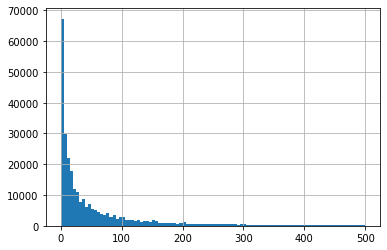

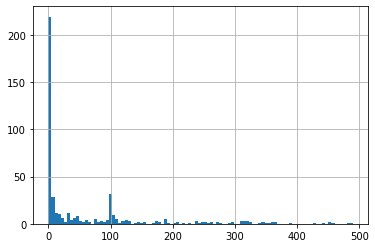

<Figure size 432x288 with 0 Axes>

In [ ]:
# GRAFICA DE CANTIDAD - Norm vs Fraud

normal_data["Amount"].loc[normal_data["Amount"] < 500].hist(bins=100);
plt.figure()
fraud_data["Amount"].loc[fraud_data["Amount"] < 500].hist(bins=100);
plt.figure()
print("Media", normal_data["Amount"].mean(), fraud_data["Amount"].mean())
print("Mediana", normal_data["Amount"].median(), fraud_data["Amount"].median())

<Figure size 432x288 with 0 Axes>

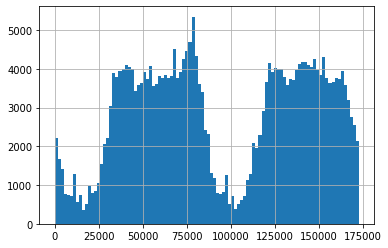

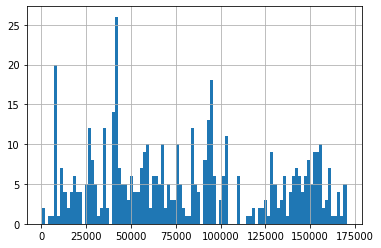

<Figure size 432x288 with 0 Axes>

In [ ]:
# Grafica Tiempo - Norm vs Fraud

normal_data["Time"].hist(bins=100);
plt.figure()
fraud_data["Time"].hist(bins=100);
plt.figure()

In [ ]:
df.drop("Time", 1, inplace=True) #eliminamos la columna del tiempo debido a que no es relevante para este analisis.

In [ ]:
X = df.drop('Class',axis=1).values 
X -= X.min(axis=0)
X /= X.max(axis=0)
y = df['Class'].values
X.shape

(284807, 29)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.1)

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input, Embedding, multiply, BatchNormalization
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
from keras.utils import to_categorical

K.set_image_dim_ordering('th')

# Salida determinista.
# si se quiere obtener distintos resultados se debe eliminar la siguiente línea
np.random.seed(1000)

# Los resultados son un poco mejores cuando la dimensionalidad del vector aleatorio es sólo 10.
# La dimensionalidad se ha dejado en 100 por coherencia con otras implementaciones de GAN.
randomDim = 100


In [ ]:
def build_generator(latent_dim,data_dim):

        model = Sequential()

        model.add(Dense(16, input_dim=latent_dim))
    
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(32, input_dim=latent_dim))
    
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(data_dim,activation='tanh'))

        model.summary()
        model.save('path_to_my_model.h5')

        noise = Input(shape=(latent_dim,))
        img = model(noise)

        return Model(noise, img)

In [ ]:
generator = build_generator(latent_dim=10,data_dim=29)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 16)                176       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 16)                64        
_________________________________________________________________
dense_49 (Dense)             (None, 32)                544       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 32)                128       
_________________________________________________________________
dense_50 (Dense)             (None, 29)                957       
Total para

In [ ]:
generator.save('path_to_my_model.h5')

In [ ]:
def build_discriminator(data_dim,num_classes):
    model = Sequential()
    model.add(Dense(31,input_dim=data_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dropout(0.25))
    model.add(Dense(16,input_dim=data_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.save('path_to_my_model2.h5')
    model.summary()
    img = Input(shape=(data_dim,))
    features = model(img)
    valid = Dense(1, activation="sigmoid")(features)
    label = Dense(num_classes+1, activation="softmax")(features)
    return Model(img, [valid, label])

In [ ]:
discriminator = build_discriminator(data_dim=29,num_classes=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 31)                930       
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 31)                0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 31)                124       
_________________________________________________________________
dropout_6 (Dropout)          (None, 31)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 16)                512       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 16)                0         
Total params: 1,566
Trainable params: 1,504
Non-trainable params: 62
_________________________________________________________________


In [ ]:
discriminator.save('path_to_my_model2.h5')

In [ ]:
optimizer = Adam(0.0002, 0.5)
discriminator.compile(loss=['binary_crossentropy', 'categorical_crossentropy'],
    loss_weights=[0.5, 0.5],
    optimizer=optimizer,
    metrics=['accuracy'])

In [ ]:
noise = Input(shape=(10,))
img = generator(noise)
discriminator.trainable = False
valid,_ = discriminator(img)
combined = Model(noise , valid)
combined.compile(loss=['binary_crossentropy'],
    optimizer=optimizer)

In [ ]:
combined.save('modelo-bueno.h5')

In [ ]:
X_train.shape

(256326, 29)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
rus = RandomUnderSampler(random_state=42)

In [ ]:
X_res, y_res = rus.fit_sample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_res.shape

(984, 29)

In [ ]:
X_res -= X_res.min()
X_res /= X_res.max()
X_test -= X_test.min()
X_test /= X_test.max()

In [ ]:
X_test_res, y_test_res = rus.fit_sample(X_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
y_res.shape

(984,)

In [ ]:
def train(X_train,y_train,
          X_test,y_test,
          generator,discriminator,
          combined,
          num_classes,
          epochs, 
          batch_size=128):
    
    f1_progress = []
    half_batch = int(batch_size / 2)
    predic = []
    noise_until = epochs

    # Pesos de clase:
    # Para equilibrar la diferencia de ocurrencias de las etiquetas de la clase de dígitos.
    # El 50% de las etiquetas sobre las que se entrena el discriminador son "falsas".
    # Peso = 1 / frecuencia
    cw1 = {0: 1, 1: 1}
    cw2 = {i: num_classes / half_batch for i in range(num_classes)}
    cw2[num_classes] = 1 / half_batch

    for epoch in range(epochs):

        # ---------------------
        #  Entrenar El Discriminador
        # ---------------------

        # Seleccione un medio lote de imágenes al azar
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        # Muestrear el ruido y generar un medio lote de imágenes nuevas
        noise = np.random.normal(0, 1, (half_batch, 10))
        gen_imgs = generator.predict(noise)
        predic.append(gen_imgs)

        valid = np.ones((half_batch, 1))
        fake = np.zeros((half_batch, 1))

        labels = to_categorical(y_train[idx], num_classes=num_classes+1)
        fake_labels = to_categorical(np.full((half_batch, 1), num_classes), num_classes=num_classes+1)

        # Entrenar El Discriminador
        d_loss_real = discriminator.train_on_batch(imgs, [valid, labels], class_weight=[cw1, cw2])
        d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, fake_labels], class_weight=[cw1, cw2])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        # ---------------------
        #  Entrenar El Generador
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, 10))
        validity = np.ones((batch_size, 1))

        # Entrenando El Discriminador
        g_loss = combined.train_on_batch(noise, validity, class_weight=[cw1, cw2])

        # Grafica del progreso
        print ("%d [D loss: %f, acc: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss))
        
        if epoch % 10 == 0:
            _,y_pred = discriminator.predict(X_test,batch_size=batch_size)
            #predic.append(y_pred)
            y_pred = np.argmax(y_pred[:,:-1],axis=1)


            f1 = f1_score(y_test,y_pred)
            print('Epoch: {}, F1: {:.5f}, F1P: {}'.format(epoch,f1,len(f1_progress)))
            f1_progress.append(f1)
            
    return f1_progress, predic

In [ ]:
f1_p, predic = train(X_res,y_res,
             X_test,y_test,
             generator,discriminator,
             combined,
             num_classes=2,
             epochs=1251, 
             batch_size=128)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.439255, acc: 46.09%, op_acc: 25.78%] [G loss: 1.320398]
Epoch: 0, F1: 0.00000, F1P: 0
1 [D loss: 0.458781, acc: 42.97%, op_acc: 32.81%] [G loss: 1.345931]
2 [D loss: 0.432440, acc: 45.31%, op_acc: 32.03%] [G loss: 1.373659]
3 [D loss: 0.414466, acc: 52.34%, op_acc: 27.34%] [G loss: 1.258122]
4 [D loss: 0.414473, acc: 49.22%, op_acc: 24.22%] [G loss: 1.313056]
5 [D loss: 0.432441, acc: 45.31%, op_acc: 35.16%] [G loss: 1.282324]
6 [D loss: 0.418889, acc: 52.34%, op_acc: 27.34%] [G loss: 1.279495]
7 [D loss: 0.410291, acc: 50.00%, op_acc: 34.38%] [G loss: 1.296750]
8 [D loss: 0.427944, acc: 44.53%, op_acc: 28.12%] [G loss: 1.288095]
9 [D loss: 0.425204, acc: 40.62%, op_acc: 35.16%] [G loss: 1.252749]
10 [D loss: 0.411164, acc: 46.88%, op_acc: 28.91%] [G loss: 1.251729]
Epoch: 10, F1: 0.00000, F1P: 1
11 [D loss: 0.389606, acc: 52.34%, op_acc: 26.56%] [G loss: 1.351701]
12 [D loss: 0.427691, acc: 46.88%, op_acc: 29.69%] [G loss: 1.220757]
13 [D loss: 0.423698, acc: 50.78%, op_a

Text(0, 0.5, 'Validación de la puntuación F1')

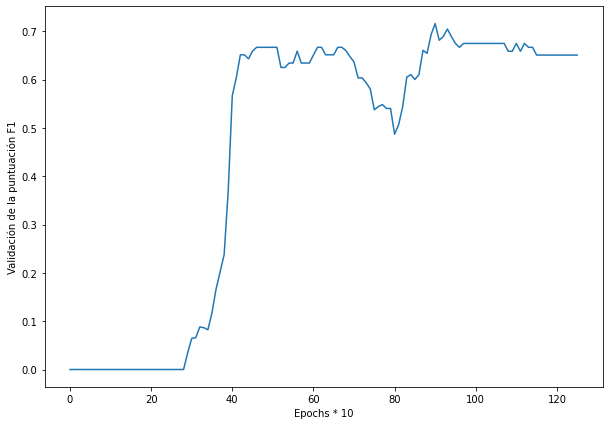

In [ ]:
fig = plt.figure(figsize=(10,7))
plt.plot(f1_p)
plt.xlabel('Epochs * 10')
plt.ylabel('Validación de la puntuación F1')

In [ ]:
f1_nuevo=max(f1_p)

for i in range(0,125):
  if (f1_p[i]==f1_nuevo):
    epoca=i*10

In [ ]:
print("El máximo f1 score es de" , 100*max(f1_p), "% a las ",epoca,"epochs")

El máximo f1 score es de 71.57894736842104 % a las  900 epochs


In [ ]:
def crear_datos_GAN(model):
  noise = np.random.normal(0, 1, (250000, 10))
  x_gen = model.predict(noise)
  print(x_gen.shape)


  _ , ygen = discriminator.predict(x_gen)

  labels_gen = np.argmax(ygen,axis=1)
  labels_fraude_indx = np.where(labels_gen==2)[0]
  labels_fraude_indx = np.random.choice(labels_fraude_indx, 1024-394, replace=False)

  gen_x_data = x_gen[labels_fraude_indx]

  train_0_indxx = np.random.choice(np.where(y_train == 0)[0], 1024, replace=False)
  train_1_indxx = np.where(y_train == 1)[0]

  indx = np.concatenate((train_0_indxx, train_1_indxx), axis=0)
  
  X_trrain_under = X_train[indx]
  y_trrain_under = y_train[indx]
  gen_y_data = np.ones((len(gen_x_data)))#ygen[labels_fraude_indx]
  X_res_gan = np.concatenate((X_trrain_under, gen_x_data), axis=0)
  y_res_gan = np.concatenate((y_trrain_under, gen_y_data), axis=0)

  return X_res_gan,y_res_gan

X_res_gan,y_res_gan = crear_datos_GAN(generator)

(250000, 29)


In [ ]:

gen_img_x = pd.DataFrame(data = X_res_gan,
                      columns = df.drop('Class',1).columns)
gen_img_x['Validacion']=y_res_gan
gen_img_x.head()



,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Validacion
0,0.953923,0.779005,0.875748,0.346807,0.767636,0.264708,0.269093,0.783605,0.426075,0.521013,0.234773,0.690818,0.509252,0.634979,0.401994,0.466831,0.708622,0.679272,0.542971,0.581834,0.564523,0.544022,0.661602,0.390246,0.562471,0.444440,0.416255,0.311638,0.000415,0.0
1,0.995280,0.760902,0.812757,0.216798,0.764058,0.260267,0.259996,0.784457,0.459615,0.509398,0.249626,0.691730,0.562756,0.565835,0.361134,0.504634,0.764207,0.620918,0.590036,0.581876,0.564982,0.544908,0.666362,0.396678,0.576098,0.410976,0.417140,0.312969,0.000777,0.0
2,0.983686,0.758559,0.840192,0.186910,0.757689,0.253635,0.261432,0.783109,0.379546,0.541923,0.366251,0.703695,0.488873,0.648360,0.309292,0.437133,0.741585,0.646181,0.588556,0.576913,0.553240,0.455340,0.668321,0.417246,0.589845,0.336251,0.416639,0.313318,0.000557,0.0
3,0.979283,0.772602,0.835241,0.298489,0.767646,0.255907,0.268533,0.782627,0.449356,0.508326,0.284131,0.729747,0.501307,0.661224,0.400329,0.432087,0.728963,0.590954,0.515202,0.578745,0.562098,0.521198,0.663597,0.397653,0.623036,0.381499,0.416756,0.313306,0.000039,0.0
4,0.932596,0.783264,0.834369,0.289706,0.770150,0.259727,0.268808,0.793054,0.411050,0.496812,0.284985,0.723511,0.410302,0.691370,0.275556,0.428810,0.738383,0.678584,0.669067,0.577957,0.564459,0.523141,0.655832,0.322587,0.641637,0.394656,0.410732,0.309896,0.000557,0.0


In [ ]:
print("La cantidad de datos con no fraude en el dataset generado son ",np.count_nonzero(y_res_gan==0),", y la cantidad con fraude son", np.count_nonzero(y_res_gan==1))
print("Vemos que la diferencia entre clases está muchísimo más balanceada que el dataset original y sería más fácil entrenar datos con este datos sintéticos")

La cantidad de datos con no fraude en el dataset generado son  1024 , y la cantidad con fraude son 1073
Vemos que la diferencia entre clases está muchísimo más balanceada que el dataset original y sería más fácil entrenar datos con este datos sintéticos


In [ ]:
real_img_x = pd.DataFrame(data = X_res,
                      columns = df.drop('Class',1).columns)
real_img_x['Validacion']=y_res
real_img_x.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Validacion
0,0.980626,0.773491,0.825863,0.283695,0.767749,0.251704,0.267725,0.782292,0.458228,0.496355,0.265939,0.696035,0.454849,0.610593,0.408687,0.468472,0.749467,0.673587,0.552683,0.579647,0.558734,0.489988,0.663335,0.355258,0.613803,0.490702,0.415877,0.313767,0.000030,0
1,0.944725,0.779763,0.853088,0.282721,0.767191,0.259810,0.268373,0.786879,0.436592,0.512251,0.334166,0.721844,0.443876,0.665320,0.363142,0.448982,0.716469,0.703000,0.630594,0.579400,0.564740,0.537027,0.664064,0.384083,0.564072,0.363367,0.409201,0.310833,0.000163,0
2,0.951649,0.764668,0.856858,0.193916,0.761409,0.263107,0.261083,0.785092,0.372221,0.551163,0.319530,0.681803,0.533314,0.634677,0.382491,0.425297,0.746679,0.723218,0.729949,0.580965,0.559328,0.515508,0.662586,0.316390,0.560518,0.426772,0.419533,0.317986,0.000584,0
3,0.957269,0.778497,0.820303,0.250620,0.766904,0.249461,0.270081,0.786832,0.457622,0.483096,0.235267,0.682088,0.387983,0.631371,0.392236,0.457825,0.751563,0.716341,0.548480,0.578458,0.567212,0.552369,0.665160,0.365219,0.558826,0.400899,0.416075,0.313983,0.002219,0
4,0.989696,0.771198,0.842080,0.423326,0.766309,0.272777,0.260957,0.787917,0.486325,0.532853,0.362444,0.631791,0.594246,0.690545,0.183488,0.491255,0.718314,0.708596,0.433813,0.577254,0.563149,0.538998,0.668360,0.475534,0.566314,0.421964,0.416145,0.312258,0.000000,0


# Autoencoders

In [ ]:
#  Normalización

data = df2.copy()
scl = StandardScaler()
all_cols = list(data)[:] 
pca_columns = list(data)[:-1] # todas las cols sin Clase
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("datos ", data.shape)
print("datos_normales ", normal_data.shape)
print("datos_fraude ", fraud_data.shape)
print("porcentaje de fraude", round(100*492/284807, 4),"%")

datos  (284807, 31)
datos_normales  (284315, 31)
datos_fraude  (492, 31)
porcentaje de fraude 0.1727 %


In [ ]:
# Los valores de comprobación se centran en 0 tras la normalización

print("datos['Tiempo'].media()  ", data['Time'].mean())
print("datos['Cantidad'].media()  ", data['Amount'].mean())

datos['Tiempo'].media()   -1.0503786406559267e-14
datos['Cantidad'].media()   3.202236423019539e-16


In [ ]:
# CREAR los conjuntos TRAIN y TEST
# Los datos de los fraudes están SOLO en TEST - no en TRAIN

normal_pca_data = normal_data[pca_columns]
fraud_pca_data = fraud_data[pca_columns]

num_test = 75000 # usaremos 75000 datos sin fraude más 492 con fraude para el test 
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(492)])

print("normal_pca_datos", normal_pca_data.shape)
print("datos_fraude_pca", fraud_pca_data.shape)
print("Datos de fraude sólo en la prueba con NINGUNO en la formación")
print("X_train ", X_train.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

normal_pca_datos (284315, 30)
datos_fraude_pca (492, 30)
Datos de fraude sólo en la prueba con NINGUNO en la formación
X_train  (209315, 30)
X_test  (75492, 30)
y_test  (75492,)


In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [ ]:
# modelo Keras y Auto Encoder 

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 30)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 14)                434       
_________________________________________________________________
dense_56 (Dense)             (None, 7)                 105       
_________________________________________________________________
dense_57 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_58 (Dense)             (None, 30)                240       
Total params: 835
Trainable params: 835
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch = 10
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="modelo-AE.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 209315 samples, validate on 75492 samples
Epoch 1/10
209315/209315 [==============================] - 18s 86us/step - loss: 0.7948 - acc: 0.3067 - val_loss: 0.8836 - val_acc: 0.3870
Epoch 2/10
209315/209315 [==============================] - 17s 81us/step - loss: 0.7222 - acc: 0.4207 - val_loss: 0.8597 - val_acc: 0.4319
Epoch 3/10
209315/209315 [==============================] - 17s 82us/step - loss: 0.7102 - acc: 0.4368 - val_loss: 0.8510 - val_acc: 0.4413
Epoch 4/10
209315/209315 [==============================] - 18s 84us/step - loss: 0.7048 - acc: 0.4449 - val_loss: 0.8464 - val_acc: 0.4448
Epoch 5/10
209315/209315 [==============================] - 18s 84us/step - loss: 0.7006 - acc: 0.4544 - val_loss: 0.8428 - val_acc: 0.4570
Epoch 6/10
209315/209315 [==============================] - 17s 84us/step - loss: 0.6963 - acc: 0.4648 - val_loss: 0.8390 - val_acc: 0.4589
Epoch 7/10
209315/209315 [==============================] - 18s 85us/step - loss: 0.6930 - acc: 0.4709 - val_

In [ ]:
# Carga el mejor modelo guardado anteriormente durante el entrenamiento

autoencoder = load_model('modelo-AE.h5')

In [ ]:
# Error de Reconstrucción en TRAIN

# Como TRAIN no tiene fraude
y_train = np.zeros(X_train.shape[0])

predictions = autoencoder.predict(X_train)
predictions.shape

mse = np.mean(np.power(X_train - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_train})
print(error_df.shape[0], ' rows')
print('error medio de reconocimiento en TRAIN', round(error_df.reconstruction_error.mean(),2))
print('error desviación estándar de reconocimiento en TRAIN', round(error_df.reconstruction_error.std(),2))

209315  rows
error medio de reconocimiento en TRAIN 0.68
error desviación estándar de reconocimiento en TRAIN 2.5


In [ ]:
# Error de reconstrucción en Test

predictions = autoencoder.predict(X_test)
predictions.shape

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
print(error_df.shape[0], ' rows')
print('error medio de reconocimiento en TEST', round(error_df.reconstruction_error.mean(),2))
print('error desviación estándar de reconocimiento en TEST', round(error_df.reconstruction_error.std(),2))

75492  rows
error medio de reconocimiento en TEST 0.82
error desviación estándar de reconocimiento en TEST 4.02


In [ ]:
# Error de reconstrucción en el fraude

# Como el fraude es todo fraude
y_Fraud = np.ones(fraud_pca_data.shape[0])
y_Fraud.shape

predictions = autoencoder.predict(fraud_pca_data)
predictions.shape

mse = np.mean(np.power(fraud_pca_data - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_Fraud})
print(error_df.shape[0], ' rows')
print('error medio de reconocimiento en FRAUD', round(error_df.reconstruction_error.mean(),2))
print('error desviación estándar de reconocimiento en FRAUD', round(error_df.reconstruction_error.std(),2))

492  rows
error medio de reconocimiento en FRAUD 22.93
error desviación estándar de reconocimiento en FRAUD 29.03


In [ ]:
# Predicciones en Normal vs. Fraude en Test ... usando el error de reconstrucción como parámetro a ajustar para obtener la mejor F1

# Error de reconstrucción en Test

predictions = autoencoder.predict(X_test)
predictions.shape

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
print(error_df.shape[0], ' rows')
print('error medio de reconocimiento en TEST', round(error_df.reconstruction_error.mean(),2))
print('error desviación estándar de reconocimiento en TEST', round(error_df.reconstruction_error.std(),2))

ReconError = 4.0

pred = [1 if e > ReconError else 0 for e in error_df.reconstruction_error.values]
len(pred)
#pred = (x <= eps)
f = f1_score(y_test, pred, average='binary')
print("Puntuación de F1 en Test", round(f,4), " con error de reconstrucción  ", ReconError)

75492  rows
error medio de reconocimiento en TEST 0.82
error desviación estándar de reconocimiento en TEST 4.02
Puntuación de F1 en Test 0.4641  con error de reconstrucción   4.0


## Optimizar el error de reconstrucción para obtener un mejor F1 score

In [ ]:
minRE = 1 # error de reconstrucción mínimo
maxRE = 50 # error de reconstrucción máximo
    
EpsF1 = []

for TryRE in range(minRE,maxRE):
    pred = [1 if e > TryRE else 0 for e in error_df.reconstruction_error.values]
    f = f1_score(y_test, pred, average='binary')
    EpsF1.append([TryRE, round(f,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['ReconError', 'F1'])
EpsF1df.head()

,ReconError,F1
0,1,0.1033
1,2,0.2823
2,3,0.3856
3,4,0.4641
4,5,0.4778


In [ ]:
#Mejor Recon Error ... Max F1 en test
print("Mejor error de reconstrucción y mejor F1 score para los autoencoders:")
EpsF1df.loc[EpsF1df['F1'].idxmax()]

Mejor error de reconstrucción y mejor F1 score para los autoencoders:


ReconError    9.0000
F1            0.5242
Name: 8, dtype: float64

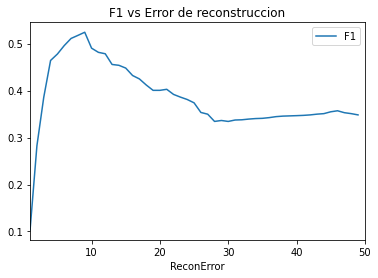

In [ ]:
EpsF1df.plot.line("ReconError","F1")
plt.xlim(1, 50)
plt.title("F1 vs Error de reconstruccion")
plt.show()